In [76]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import imp

In [394]:
from sympy import *
from sympy.printing.str import StrPrinter
from sympy.printing.latex import LatexPrinter

In [77]:
import numpy as np
from scipy.special import psi
from statsmodels.sandbox.regression.gmm import GMM

In [78]:
import sys
sys.path.append('simulate.py')
import simulate as sim

In [79]:
imp.reload(sim)

<module 'simulate' from '/wynton/group/ye/mincheol/Github/scrna-parameter-estimation/examples/simulation/method_of_moments/simulate.py'>

In [80]:
p = 0.1
noise_level = 0.2049755522580501
p_sq = (noise_level+1)*p**2

In [216]:
X, z = sim.simulate_true_counts(
    N=5000,
    mean_coef = np.array([1, 0.1]),
    var_coef = np.array([2, 0.1]),
    num_levels=2,
    p=1)

y = sim.simulate_dropout(z, p, p_sq) 

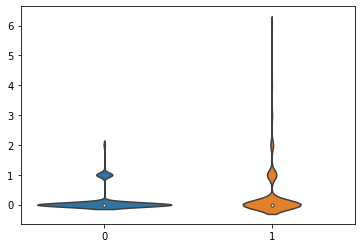

In [222]:
sns.violinplot(pd.Series(X[:, 0]), y.ravel())

### statsmodels based GMM

In [425]:
class MeanGMM(GMM):

    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 2)
        kwds.setdefault('k_params', 2)
        super(MeanGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
                
        y = self.endog.reshape(-1, 1)
        x_mat = self.exog

        beta_hat = params.reshape(-1, 1)
        
        a =  (x_mat*y)/self.q - (x_mat*np.exp(x_mat@beta_hat))
        return a
    
class VarianceGMM(GMM):

    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 2)
        kwds.setdefault('k_params', 2)
        super(VarianceGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
                
        y = self.endog.reshape(-1, 1)
        x_mat = self.exog
        mean_beta = self.mean_beta.reshape(-1, 1)

        var_beta = params.reshape(-1, 1)
        
        a = (x_mat*y**2)/self.q_sq
        b = -(x_mat*y)*(1-self.q_sq/self.q)/self.q_sq
        c = -2*y*np.exp(x_mat@mean_beta)*x_mat/self.q
        d = np.exp(2*x_mat@mean_beta)*x_mat
        e = -x_mat*np.exp(x_mat@(self.gamma*mean_beta + var_beta))
        return a + b + c + d + e

class CombinedGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 4)
        kwds.setdefault('k_params', 4)
        super(CombinedGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
                
        y = self.endog.reshape(-1, 1)
        x_mat = self.exog

        mean_beta, var_beta = np.split(params.reshape(-1, 1), 2)
                
        mean_error =  (x_mat*y)/self.q - (x_mat*np.exp(x_mat@mean_beta))
        
        a = (x_mat*y**2)/self.q_sq
        b = -(x_mat*y)*(1-self.q_sq/self.q)/self.q_sq
        c = -2*y*np.exp(x_mat@mean_beta)*x_mat/self.q
        d = np.exp(2*x_mat@mean_beta)*x_mat
        e = -x_mat*np.exp(x_mat@(self.gamma*mean_beta + var_beta))
        
        var_error = a + b + c + d + e
    
        return np.hstack([mean_error, var_error])

In [ ]:
class MeanGMM(GMM):

    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 2)
        kwds.setdefault('k_params', 2)
        super(MeanGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
                
        y = self.endog.reshape(-1, 1)
        x_mat = self.exog

        beta_hat = params.reshape(-1, 1)
        
        a =  (x_mat*y)/self.q - (x_mat*np.exp(x_mat@beta_hat))
        return a

In [428]:
X, z = sim.simulate_true_counts(
    N=100000,
    mean_coef = np.array([1.5, 0.1]),
    var_coef = np.array([1.6, 0.1]),
    num_levels=2,
    p=1)

y = sim.simulate_dropout(z, p, p_sq)

df = pd.DataFrame(
    data=np.hstack([X, y]),
    columns=['treatment', 'intercept', 'y'])
df = df.groupby(df.columns.tolist()).size().reset_index(name='count')
df['proportion'] = df['count'] / X.shape[0]

In [429]:
X, z = sim.simulate_true_counts(
    N=100000,
    mean_coef = np.array([1.5, 0.1]),
    var_coef = np.array([1.6, 0.1]),
    num_levels=2,
    p=1)

y = sim.simulate_dropout(z, p, p_sq)

df = pd.DataFrame(
    data=np.hstack([X, y]),
    columns=['treatment', 'intercept', 'y'])
df = df.groupby(df.columns.tolist()).size().reset_index(name='count')
df['proportion'] = df['count'] / X.shape[0]

init = np.ones(2)*(np.log(y+1).mean()/2)

mean_model = MeanGMM(df[['y', 'count']], df[['treatment', 'intercept']], instrument=None, q=p, q_sq=p_sq)
mean_res = mean_model.fit(init, maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))
mean_beta = mean_res.params

# var_model = VarianceGMM(y, X, instrument=None, q=p, q_sq=p_sq, mean_beta=mean_beta, gamma=1)
# var_res = var_model.fit(init, maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))

# combined_model = CombinedGMM(y, X, instrument=None, q=p, q_sq=p_sq, gamma=1)
# combined_res = combined_model.fit(np.concatenate([init, init]), maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))


print(mean_res.summary())
# print(var_res.summary())
# print(combined_res.summary())

                               MeanGMM Results                                
Dep. Variable:         ['y', 'count']   Hansen J:                    1.731e-15
Model:                        MeanGMM   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date:                Sun, 13 Oct 2019                                         
Time:                        21:09:54                                         
No. Observations:                  17                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      1.4116      0.414      3.413      0.001       0.601       2.222
intercept      2.7081      0.373      7.266      0.000       1.978       3.438


In [403]:
%%time
mean_res = mean_model.fit(init, maxiter=2, optim_method='bfgs', optim_args={'disp':True}, wargs=dict(centered=False))


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
CPU times: user 228 ms, sys: 206 µs, total: 228 ms
Wall time: 223 ms


In [404]:
%%time
var_res = var_model.fit(init, maxiter=2, optim_method='bfgs', optim_args={'disp':True}, wargs=dict(centered=False))


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
CPU times: user 759 ms, sys: 0 ns, total: 759 ms
Wall time: 756 ms


In [1]:
import cvxpy

In [2]:
import cvxpy as cp
import numpy as np

# Problem data.
m = 30
n = 20
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A*x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print(x.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print(constraints[0].dual_value)

[-1.79109253e-19  2.85112420e-02  2.79973443e-19  3.37658751e-20
 -2.72802659e-19  1.49285011e-01 -9.97212062e-20  8.35373892e-20
  2.46718649e-01  5.78224144e-01 -4.03739462e-19  1.01242860e-03
 -9.28486200e-20  2.26767464e-01 -1.58813677e-19 -8.97232308e-20
 -1.22145726e-19 -1.51509432e-19  1.12060673e-19 -3.48318630e-19]
[ 2.50938945  0.          2.78354615  1.79425782 13.08579183  0.
  0.73716363  3.35344995  0.          0.          8.93825054  0.
  7.02955161  0.          4.71068649  3.18873635  2.06090107 10.08166738
  3.0481157   8.53268239]
